<h1 style="font-family:Corbel Light; color:#00ced1">Projet 5 : Segmentez des clients d'un site e-commerce </h1>

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#00ced1">Étape 1</span> : Analyse exploratoire </h2>

<h3 style="font-family:Corbel Light; color:#737373">Requirements</h3>

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import toolbox
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Binarizer
from sklearn.decomposition import PCA

%matplotlib inline
pd.options.display.float_format = '{:_.2f}'.format

In [2]:
python_version = !python -V
print('python version :', python_version, '\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('scikit-learn version : ', sklearn.__version__, '\n')

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.21.5 

matplotlib version :  3.5.1 

seaborn version :  0.12.1 

scikit-learn version :  1.2.1 



**Versions utilisées :**

- python : Python 3.9.12 
- seaborn    :  0.12.1
- matplotlib :  3.5.1 
- numpy  :  1.21.5 
- pandas :  1.4.2
- scikit-learn :  1.2.1

<h3 style="font-family:Corbel Light; color:#737373">Inspection des données</h3>

On a 9 fichiers contenant des données de septembre 2016 à octobre 2018.

- olist_customers_dataset.csv : **une ligne par commande** - id et localisation des clients (ville, état, zip code)
- olist_geolocation_dataset.csv : données de géolocalisation de villes brésiliennes (longitude, latitude, zip code, état)
- olist_order_items_dataset.csv : **une ligne par produit commandé** - si un même produit a été commandé n fois dans une même commande alors n lignes pour la même commande (id commande, id produit, id vendeur, prix, date d'expedition, frais de port)
- olist_order_payments_dataset.csv : **une ligne par paiement effectué** - si n méthodes de paiement ont été utilisées pour régler une même commande alors n lignes pour une même commande -
- olist_order_reviews_dataset : commentaires et notes de satisfaction
- olist_orders_dataset : **une ligne par commande** (date de commande, date de livraison...)
- olist_products_dataset : **une ligne par produit** - catalogue des produits en vente
- olist_sellers : **une ligne par vendeur** 
- product_category_name_translation : **une ligne par produit** - mapping nom produit portugais/anglais -

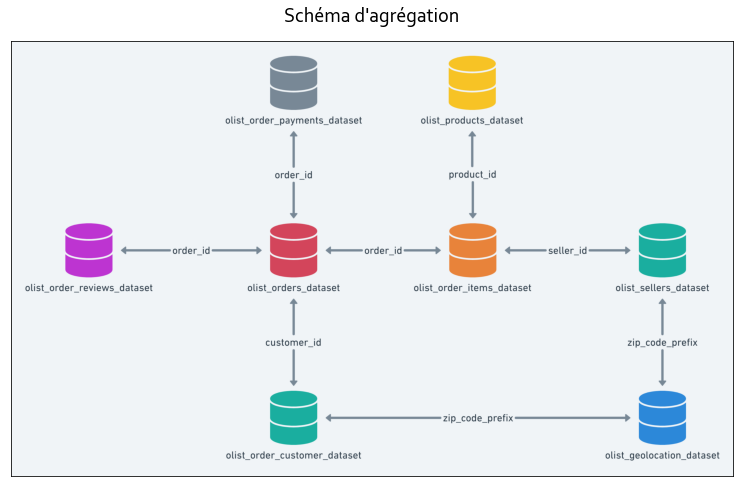

In [3]:
url = 'https://i.imgur.com/HRhd2Y0.png'
toolbox.display_image(url, 'Schéma d\'agrégation', (15, 8))

<h4 style="font-family:Corbel Light; color:#737373">ID et localisation clients</h4>

In [4]:
customer_data = pd.read_csv('olist_customers_dataset.csv')
customer_data.shape

(99441, 5)

On affiche les 5 premières lignes du dataframe 

In [5]:
customer_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


On regarde la structure des données

In [6]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Regardons les doublons : 

La clé primaire de cette table est 'customer_id'. Il y a une ligne par commande. 

Un client est identifié par 'customer_unique_id'. Chaque fois qu'un client fait une nouvelle commande, un nouveau 'customer_id' est crée. Donc un client ayant fait 2 commandes a 2 'customer_id' associés et un unique 'customer_unique_id'. Il y a 96_096 clients différents.

In [7]:
customer_data['customer_id'].duplicated().value_counts()

False    99441
Name: customer_id, dtype: int64

In [8]:
customer_data['customer_unique_id'].duplicated().value_counts()

False    96096
True      3345
Name: customer_unique_id, dtype: int64

In [9]:
duplicates_mask = customer_data['customer_unique_id'].duplicated(keep=False)
duplicates = customer_data.loc[duplicates_mask, :]
duplicates.sort_values('customer_unique_id').head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
19299,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL


<h4 style="font-family:Corbel Light; color:#737373">Geolocalisation des villes</h4>

Remarque : On ne va pas utiliser les critères géographiques dans notre segmentation car on veut rester sur un modèle simple, facilement utilisable par le service marketing.

In [10]:
geolocation_data = pd.read_csv('olist_geolocation_dataset.csv')
geolocation_data.shape

(1000163, 5)

In [11]:
geolocation_data.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.55,-46.64,sao paulo,SP
1,1046,-23.55,-46.64,sao paulo,SP
2,1046,-23.55,-46.64,sao paulo,SP
3,1041,-23.54,-46.64,sao paulo,SP
4,1035,-23.54,-46.64,sao paulo,SP


In [12]:
geolocation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


<h4 style="font-family:Corbel Light; color:#737373">Produits commandés</h4>

In [13]:
items_data = pd.read_csv('olist_order_items_dataset.csv')
items_data.shape

(112650, 7)

In [14]:
items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
items_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Regardons les doublons :

Chaque ligne correspond à un produit commandé. Si dans une même commande, le même produit est commandé 4 fois, on aura 4 fois la même ligne. 

In [16]:
items_data['order_id'].duplicated().value_counts()

False    98666
True     13984
Name: order_id, dtype: int64

In [17]:
duplicates = items_data.loc[items_data['order_id'].duplicated(keep=False), :]
duplicates.sort_values('order_id')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112634,fff8287bbae429a99bb7e8c21d151c41,1,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


La clé primaire de cette table est l'agrégation des 3 colonnes 'order_id', 'product_id', 'order_item_id'

In [18]:
subset = ['order_id', 'product_id', 'order_item_id']
items_data.duplicated(subset).value_counts()

False    112650
dtype: int64

In [19]:
items_data.loc[items_data['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83


<h4 style="font-family:Corbel Light; color:#737373">Historique des paiements</h4>

In [20]:
payments_data = pd.read_csv('olist_order_payments_dataset.csv')
payments_data.shape

(103886, 5)

In [21]:
payments_data.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Regardons les doublons : 

Chaque ligne correspond à une méthode de paiement utilisée pour régler une commande. 

Si deux méthodes différentes ont été utilisées pour régler une même commande (ex: coupon et carte de crédit), 2 lignes sont créées. La colonne payment_sequential reprend le nombre de méthodes de paiement utilisées.

In [22]:
duplicates_mask = payments_data['order_id'].duplicated(keep=False)
duplicates = payments_data.loc[duplicates_mask, :]
duplicates.sort_values(['order_id', 'payment_sequential'])

,order_id,payment_sequential,payment_type,payment_installments,payment_value
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


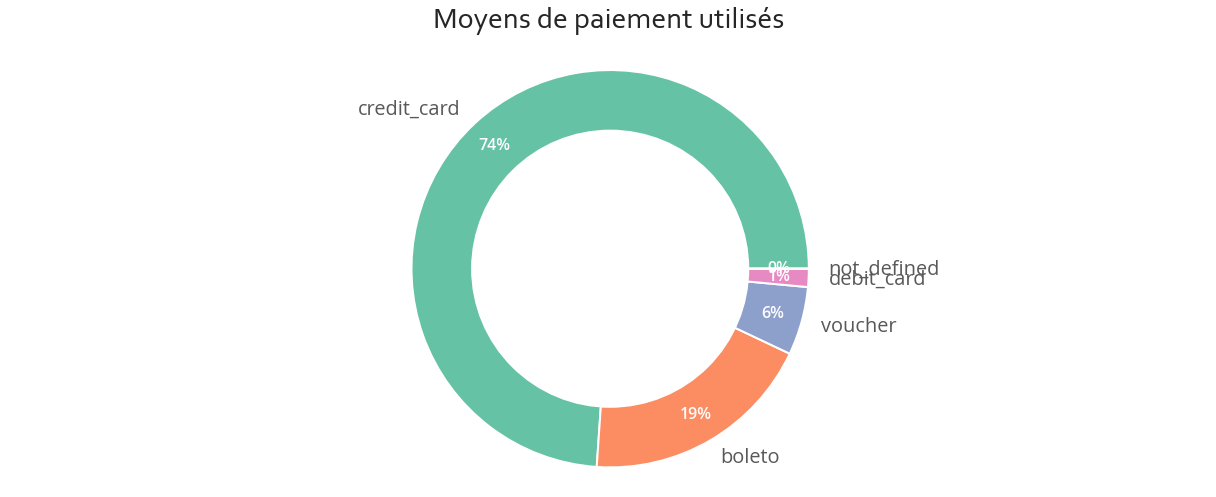

In [23]:
toolbox.plot_donut(payments_data, 'payment_type',
                   'Moyens de paiement utilisés', (17, 7))

remarque : boleto = moyen de paiement en espèces très utilisé au Brésil, notamment par les clients qui ne possèdent pas de compte bancaire (abréviation de Boleto Bancário)

<h4 style="font-family:Corbel Light; color:#737373">Commentaires de satisfaction</h4>

In [24]:
reviews_data = pd.read_csv('olist_order_reviews_dataset.csv')
reviews_data.shape

(99224, 7)

In [25]:
reviews_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [26]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Mettons les colonnes contenant des dates au bon format.

In [27]:
date_columns = ['review_creation_date', 'review_answer_timestamp']

for feature in date_columns:
    reviews_data[feature] = pd.to_datetime(reviews_data[feature],
                                           errors='coerce',
                                           format='%Y-%m-%d %H:%M:%S')

In [28]:
reviews_data['review_id'].duplicated().value_counts()

False    98410
True       814
Name: review_id, dtype: int64

In [29]:
mask_duplicates = reviews_data['review_id'].duplicated(keep=False)
duplicates = reviews_data.loc[mask_duplicates, :]
duplicates.sort_values('review_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53
...,...,...,...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ...",2018-02-28,2018-02-28 13:57:52
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,NaN,NaN,2017-07-22,2017-07-26 13:41:07


In [30]:
duplicates.sort_values('order_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25,2017-08-29 21:45:57
7629,0501aab2f381486c36bf0f071442c0c2,0068c109948b9a1dfb8530d1978acef3,1,NaN,Espero obter uma resposta para minha encomenda...,2018-02-09,2018-02-10 23:55:18
33124,a555fec0a2d54ccb104762e54f058603,00a250dbdb3153cc6ecf4d3f07ef6a17,2,NaN,"Fiz um pedido de 4 itens, ele foi separado em ...",2017-12-17,2017-12-17 18:25:11
78935,17939259ccc419f355fb4a148151fb00,00d94e8901b75ee0d6ef1f87f947b666,4,NaN,NaN,2017-05-24,2017-05-26 18:54:13
30797,32e2c7e889f7a185d462265398ee3631,00d9ac423c9ad6781c0ed04e87666691,5,NaN,NaN,2017-10-21,2017-10-22 00:47:25
...,...,...,...,...,...,...,...
5500,1a6be4c794d5e3da242a364f6a98163f,ff536d93ae4214b4d51c2894ccfc569f,3,NaN,Chigling,2017-12-28,2017-12-28 22:54:59
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18,2017-11-18 09:02:48
94504,c56a88a404315a0d9e412c1472dda2c4,ff763b73e473d03c321bcd5a053316e8,5,NaN,NaN,2017-11-01,2017-11-01 19:55:52
53962,5476dd0eaee7c4e2725cafb011aa758c,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20,2017-12-21 13:24:55


<h4 style="font-family:Corbel Light; color:#737373">Historique des Commandes</h4>

In [31]:
order_data = pd.read_csv('olist_orders_dataset.csv')
order_data.shape

(99441, 8)

In [32]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Mettons les colonnes contenant des dates au bon format.

In [33]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for feature in date_columns:
    order_data[feature] = pd.to_datetime(order_data[feature],
                                         format='%Y-%m-%d %H:%M:%S',
                                         errors='coerce')

Regardons les doublons : 

La clé primaire de cette table est 'order_id'. Il y a une ligne par commande.

In [34]:
order_data['order_id'].duplicated().value_counts()

False    99441
Name: order_id, dtype: int64

In [35]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [36]:
len(order_data['customer_id'].unique())

99441

Regardons de quand datent nos données : On a des commandes entre Septembre 2016 et Octobre 2018

In [37]:
less_recent_order = order_data['order_purchase_timestamp'].min()
most_recent_order = order_data['order_purchase_timestamp'].max()

print('Plus ancienne commande du jeu de données : {}'.format(less_recent_order))
print('Commande la plus récente du jeu de données : {}'.format(most_recent_order))

Plus ancienne commande du jeu de données : 2016-09-04 21:15:19
Commande la plus récente du jeu de données : 2018-10-17 17:30:18


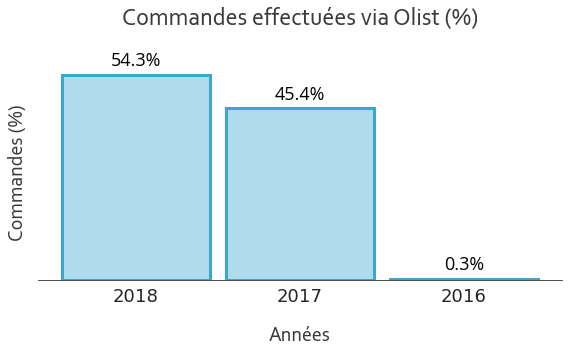

In [38]:
order_sorted = order_data.sort_values('order_purchase_timestamp',
                                      ascending=False)
order_year = order_sorted['order_purchase_timestamp'].dt.year.astype(str)

color = sns.color_palette("husl", 8)[5]
titles = {'chart_title': 'Commandes effectuées via Olist (%)',
          'y_title': 'Commandes (%)',
          'x_title': 'Années'}

toolbox.plot_empirical_distribution(order_year, color, titles, (8, 5))

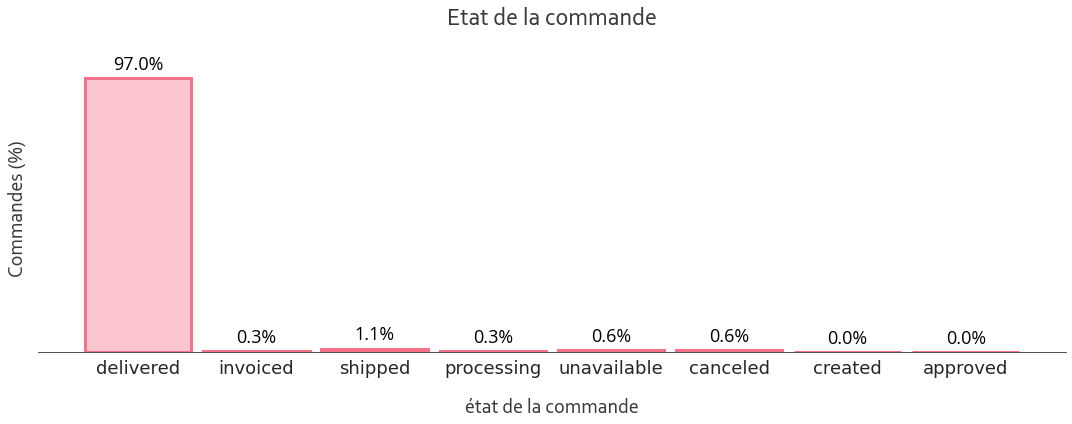

In [39]:
color = sns.color_palette("husl", 8)[0]
titles = {'chart_title': 'Etat de la commande',
          'y_title': 'Commandes (%)',
          'x_title': 'état de la commande'}

toolbox.plot_empirical_distribution(order_data['order_status'],
                                    color, titles, (15, 6))

Regardons quel est le problème avec les commandes pour lesquelles le statut n'est pas "delivered"

Remarque : Nous allons garder toutes les commandes même celles qui présentent un problème et qui ont été annulées car on s'intéresse ici à l'intention d'achat du client, même s'il a changé d'avis après avoir commandé.

In [40]:
order_with_issue = order_data.loc[order_data['order_status'] != 'delivered',
                                  ['order_id', 'order_status']].copy()

comment = reviews_data[['review_comment_message', 'order_id']]
order_with_issue = order_with_issue.merge(comment, on='order_id', how='left')

pay = payments_data.groupby('order_id')['payment_value'].sum().reset_index()
order_with_issue = order_with_issue.merge(pay, on='order_id', how='left')

order_with_issue.head()

,order_id,order_status,review_comment_message,payment_value
0,136cce7faa42fdb2cefd53fdc79a6098,invoiced,fiquei triste por n ter me atendido.,65.95
1,ee64d42b8cf066f35eac1cf57de1aa85,shipped,NaN,22.36
2,0760a852e4e9d89eb77bf631eaaf1c84,invoiced,"Gostei do produto, porem fiquei preocupada não...",50.35
3,15bed8e2fec7fdbadb186b57c46c92f2,processing,NaN,138.28
4,6942b8da583c2f9957e990d028607019,shipped,NaN,69.12


Exemples de cas avec le statut **"unavailable"**: 
   - '8e24261a7e58791d10cb1bf9da94df5c' le client a payé 84 réaux mais le produit n'était plus en stock : 
       - Commentaire : "Anunciam um produto que não tem em estoque e ainda não cancelaram a compra no meu cartão!" = **"They advertise a product that they don't have in stock and they still haven't canceled the purchase on my card!"**
       
   - '37553832a3a89c9b2db59701c357ca67' le client a payé 132.46 réaux mais n'a reçu ni produit, ni remboursement
       - Commentaire : "Até hoje não recebi meu produto e nem uma resposta sobre o ressarcimento.Aguardo uma solução para que eu continue a comprar com o stark." = **Until today I have not received my product or a response about the refund. I am waiting for a solution so that I can continue to buy with stark**
       
   - '2f634e2cebf8c0283e7ef0989f77d217' le client a payé 615.53 réaux mais n'a pas reçu le produit
        - Commentaire : Comprei um perfume Bleu de Chanel , paguei e não recebi = **I bought a Bleu de Chanel perfume, I paid and I didn't receive it**

In [41]:
order_with_issue.loc[order_with_issue['order_status'] == 'unavailable']

,order_id,order_status,review_comment_message,payment_value
7,8e24261a7e58791d10cb1bf9da94df5c,unavailable,Anunciam um produto que não tem em estoque e a...,84.00
19,c272bcd21c287498b4883c7512019702,unavailable,NaN,97.68
22,37553832a3a89c9b2db59701c357ca67,unavailable,Até hoje não recebi meu produto e nem uma resp...,132.46
24,d57e15fb07fd180f06ab3926b39edcd2,unavailable,Não compre,134.38
29,2f634e2cebf8c0283e7ef0989f77d217,unavailable,"Comprei um perfume Bleu de Chanel , paguei e n...",615.53
...,...,...,...,...
2976,6cf5c427fb11bc5fe8abefa86aa7ba0b,unavailable,NaN,131.78
2978,1c7c8ab324927f5b6e52338bd110bef4,unavailable,Eu fiz a compra no 23/12/2017 e não no dia 19/...,934.09
2979,aaab15da689073f8f9aa978a390a69d1,unavailable,"UMA BOSTA NAO ENTREGA, E NAO FAZ ESTORNO DO VA...",210.09
2983,a69ba794cc7deb415c3e15a0a3877e69,unavailable,Fiz a compra do produto para presentear uma pe...,195.91


Exemples de cas avec le statut **"canceled"** = la commande a été annulée (aucune info de suivi dans les données dispo)
 - 'ed3efbd3a87bea76c2812c66a0b32219'
    - Commentaire : 'O produto veio com defeito ele não liga não funciona quero trocar'=**'The product came with a defect it doesn't turn on it doesn't work I want to exchange it'**
 - '00b1cb0320190ca0daa2c88b35206009'
    - Commentaire : 'Comprei dois fones de ouvido com valor de r50.32 e entregaram o cabo para para iPhone no valor de r$ 10' = **'I bought two headphones worth BRL 50.32 and they delivered the cable for the iPhone worth BRL 10'**

In [42]:
order_with_issue.loc[order_with_issue['order_status'] == 'canceled']

,order_id,order_status,review_comment_message,payment_value
13,1b9ecfe83cdc259250e1a8aca174f0ad,canceled,NaN,33.34
20,714fb133a6730ab81fa1d3c1b2007291,canceled,Olá!\r\nMinha queixa é a não entrega na residê...,96.01
21,714fb133a6730ab81fa1d3c1b2007291,canceled,Holá!\r\nNão recebi o produto é nem um telefon...,96.01
27,3a129877493c8189c59c60eb71d97c29,canceled,Não recebi o produto e também não tive reembolso,51.00
28,00b1cb0320190ca0daa2c88b35206009,canceled,Comprei dois fones de ouvido com valor de R$ 5...,0.00
...,...,...,...,...
2965,b159d0ce7cd881052da94fa165617b05,canceled,NaN,30.66
2968,e49e7ce1471b4693482d40c2bd3ad196,canceled,Preciso trocar os copos pois vieram errados. O...,54.42
2975,6560fb10610771449cb0463c5ba12199,canceled,Após o produto faturado a loja enviou e-mail q...,333.62
2980,3a3cddda5a7c27851bd96c3313412840,canceled,NaN,63.89


Exemples de cas avec le status 'created': 
- 'o PRODUTO NÃO CHEGOU ATÉ HOJE.' = **'THE PRODUCT DIDN'T ARRIVE UNTIL TODAY.'**
- 'Embora o produto estivesse em falta a empresa fez o contato para avisar e cancelou o pedido.' = **'Although the product was out of stock, the company made contact to notify and canceled the order.'**

In [43]:
order_with_issue.loc[order_with_issue['order_status'] == 'created']

,order_id,order_status,review_comment_message,payment_value
213,b5359909123fa03c50bdb0cfed07f098,created,o PRODUTO NÃO CHEGOU ATÉ HOJE.,160.94
262,dba5062fbda3af4fb6c33b1e040ca38f,created,NaN,137.60
622,7a4df5d8cff4090e541401a20a22bb80,created,NaN,37.84
1647,35de4050331c6c644cddc86f4f2d0d64,created,NaN,105.87
1763,90ab3e7d52544ec7bc3363c82689965f,created,Embora o produto estivesse em falta a empresa ...,245.85


Cas avec le statut "invoiced" (facturé):
- 'meu produto não chegou ,prazo de entrega de 34 dias e mesmo assim nao foi entregue ,não recomendo' = **'my product did not arrive, delivery time of 34 days and still not delivered, I do not recommend'**
- 'Até agora não recebi o produto, e já foi descontado 2 prestações no meu cartão, estou esperando solução do stark para não tomar medidas mais drásticas.' = **'Until now I haven't received the product, and 2 installments have already been deducted from my card, I'm waiting for Stark's solution so as not to take more drastic measures.'**

In [44]:
order_with_issue.loc[order_with_issue['order_status'] == 'invoiced']

,order_id,order_status,review_comment_message,payment_value
0,136cce7faa42fdb2cefd53fdc79a6098,invoiced,fiquei triste por n ter me atendido.,65.95
2,0760a852e4e9d89eb77bf631eaaf1c84,invoiced,"Gostei do produto, porem fiquei preocupada não...",50.35
16,38b7efdf33dd5561f4f5d4f6e07b0414,invoiced,Meu produto não chegou. Isso gerou estresse e ...,44.09
50,51b0dccc8596ce37a930dff2d63a10a2,invoiced,NaN,117.68
57,5504eaa5a86eb25fa666cf2e6b96c701,invoiced,não recomendo,131.57
...,...,...,...,...
2953,41ad2ae32ee66c07ef3b0301ba02ad27,invoiced,NaN,141.23
2960,9ffb325177b96c422447e3b9ee9a6270,invoiced,Não recebi o produto ainda e não consegui entr...,263.55
2966,021dac6e3120485db6a77474aa21b979,invoiced,"A empresa não esntregou o produto, a lannister...",534.36
2970,c526fe83c01c48066394ff5d81f9ab9a,invoiced,Não recebi meu produto ainda!,134.36


Cas avec statut 'shipped' : 
- Comprei o produto dia 06/10/2016 hj é 15/12/2016 SENDO QUE ERA 38 DIAS DE ENTREGA JÁ FAZEM MAIS DE 60 DIAS E NADA NÃO RECEBI O PRODUTO NÃO CONSIGO LIGAÇÃO PRAS AS lannister SÓ DA OCUPADO = **I bought the product on 10/06/2016 today is 12/15/2016 AND IT WAS 38 DAYS OF DELIVERY IT HAS ALREADY BEEN MORE THAN 60 DAYS AND NOTHING I HAVE NOT RECEIVED THE PRODUCT I CANNOT REACH THE LANNISTER**

In [45]:
order_with_issue.loc[order_with_issue['order_status'] == 'shipped']

,order_id,order_status,review_comment_message,payment_value
1,ee64d42b8cf066f35eac1cf57de1aa85,shipped,NaN,22.36
4,6942b8da583c2f9957e990d028607019,shipped,NaN,69.12
5,36530871a5e80138db53bcfd8a104d90,shipped,NaN,63.79
6,4d630f57194f5aba1a3d12ce23e71cd9,shipped,NaN,240.23
8,3b4ad687e7e5190db827e1ae5a8989dd,shipped,Comprei um produto e não entregaram. \r\nPedi ...,865.01
...,...,...,...,...
2963,dab8a6c6bd6ec448df5b3a6b6cb887bc,shipped,NaN,121.90
2964,dab8a6c6bd6ec448df5b3a6b6cb887bc,shipped,"Não sei ainda , pós o que eu comprei não chegou",121.90
2969,492aed3c33bac22a8e04138319829283,shipped,NaN,280.42
2973,274a7f7e4f1c17b7434a830e9b8759b1,shipped,O produto não foi entregue em que pese já ter ...,57.94


Statut 'processing': 
- estou aguardando o produto chegar = **I'm waiting for the product to arrive**

In [46]:
order_with_issue.loc[order_with_issue['order_status'] == 'processing']

,order_id,order_status,review_comment_message,payment_value
3,15bed8e2fec7fdbadb186b57c46c92f2,processing,NaN,138.28
10,d3c8851a6651eeff2f73b0e011ac45d0,processing,NaN,299.84
25,6a6c7d523fd59eb5bbefc007331af717,processing,estou aguardando o produto chegar,176.61
31,745e1d4a7f8c4b548881788d4113bb1d,processing,NaN,48.00
37,1d52ba7197c7acebbb4f826f6585536f,processing,Não recebi meu produto dentro do prazo e o ate...,286.09
...,...,...,...,...
2925,dcdfc540e42725663242bb884c28f0a6,processing,NaN,68.63
2938,e471815e7114cdb474064f7dbb1a8b67,processing,Péssimo! Além de não entregarem o produto comp...,482.61
2942,10951d02d64917a34959abeb8130601e,processing,Já comprei nas lojas amerinas e não tive prome...,59.58
2974,aea0db338150b526dde24f6fd953a5ed,processing,NaN,113.34


<h4 style="font-family:Corbel Light; color:#737373">Catalogue de produits</h4>

In [47]:
products_data = pd.read_csv('olist_products_dataset.csv')
products_data.shape

(32951, 9)

In [48]:
products_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.00,287.00,1.00,225.00,16.00,10.00,14.00
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.00,276.00,1.00,1_000.00,30.00,18.00,20.00
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.00,250.00,1.00,154.00,18.00,9.00,15.00
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.00,261.00,1.00,371.00,26.00,4.00,26.00
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.00,402.00,4.00,625.00,20.00,17.00,13.00


In [49]:
products_data['product_id'].duplicated().value_counts()

False    32951
Name: product_id, dtype: int64

In [50]:
products_data.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Il manque le nom de la catégorie pour 610 produits. On ne pourra pas les remplacer, ni les deviner. 

On ne va pas utiliser la catégorie du produit comme critère de segmentation pour l'instant. On y reviendra si vraiment on n'arrive pas à trouver un clustering satisfaisant avec les autres variables dont on dispose.

<h4 style="font-family:Corbel Light; color:#737373">Localisation des vendeurs</h4>

In [51]:
sellers_data = pd.read_csv('olist_sellers_dataset.csv')
sellers_data.shape

(3095, 4)

In [52]:
sellers_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [53]:
sellers_data['seller_id'].duplicated().value_counts()

False    3095
Name: seller_id, dtype: int64

<h4 style="font-family:Corbel Light; color:#737373">Mapping des noms de produits portugais/anglais</h4>

In [54]:
category_data = pd.read_csv('product_category_name_translation.csv')
category_data.shape

(71, 2)

In [55]:
category_data.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


Par curiosité, regardons quelles catégories de produits sont le plus commandées dans notre jeu de données.

Cette variables catégorielle prend beaucoup de modalités différentes, ce qui nous conforte dans le fait de ne pas l'utiliser de suite pour entrainer nos premiers modèles.

In [56]:
c = pd.merge(items_data, products_data, how='left', on='product_id')
c = c.merge(category_data, how='left', on='product_category_name')

In [57]:
c['product_category_name_english'] = c['product_category_name_english'].fillna('unknown')

In [58]:
c_df = toolbox.build_frequency_df_with_thresh(c, 'product_category_name_english', 0.01, 
                                              'autres (commandes < {} %)'
                                             )

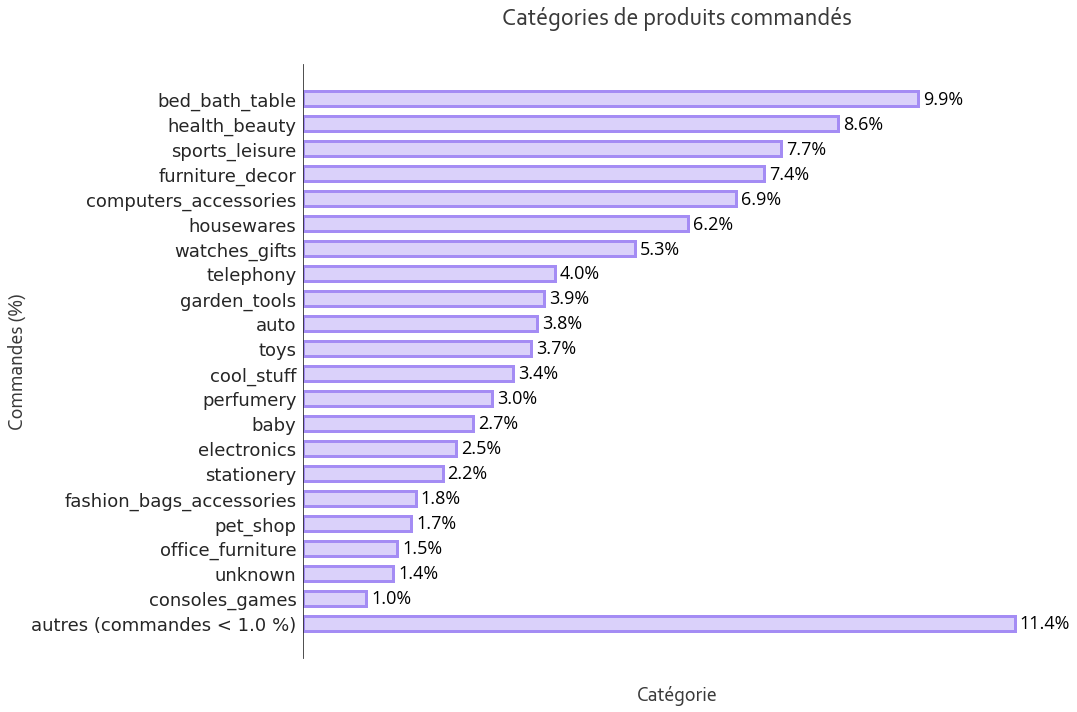

In [59]:
color = sns.color_palette("husl", 8)[6]
titles = {'chart_title': 'Catégories de produits commandés',
          'y_title': 'Commandes (%)',
          'x_title': 'Catégorie'}

toolbox.plot_empirical_distribution(c_df['product_category_name_english'],
                                    color, titles, (15, 10), vertical=False)

<h3 style="font-family:Corbel Light; color:#737373">Agrégation des données</h3>

On va agréger les différentes tables pour obtenir un jeu de données à partir duquel créer nos nouvelles variables. On va commencer par créer un "master dataset" avec une ligne par commande. Puis dans la partie "feature engineering" on créera un dataset avec une ligne par client.

<h4 style="font-family:Corbel Light; color:#737373">"MasterDataset" avec une ligne par commande</h4>

Commençons par agréger la table 'olist_order_customer_dataset' (qui contient les infos sur les clients) et 'olist_orders_dataset' (qui contient la liste des commandes) sur la clé 'customer_id', sachant qu'un même client peut avoir fait plusieurs commandes. 

La clé primaire de ce nouveau dataframe 'master_dataset' sera 'order_id', une ligne par commande.

In [60]:
master_dataset = pd.merge(order_data, customer_data, on='customer_id', how='left', indicator=True)

On vérifie que la fusion a fonctionné.

In [61]:
master_dataset['_merge'].value_counts()

both          99441
left_only         0
right_only        0
Name: _merge, dtype: int64

In [62]:
master_dataset.drop(columns='_merge', inplace=True)

Ajoutons des informations qui nous serviront au moment du feature engineering :

- le jour de la semaine auquel la commande a été passée
- l'heure à laquelle la commande a été passée
- le nombre de jours entre la date d'achat et de livraison
- le nombre de jours entre la date de livraison prévue et la date à laquelle la commande a finalement été livrée

In [63]:
master_dataset['order_weekday'] = master_dataset['order_purchase_timestamp'].dt.weekday
master_dataset['order_hour'] = master_dataset['order_purchase_timestamp'].dt.hour

master_dataset['delivery_days_n'] = (
    master_dataset['order_delivered_customer_date'] - master_dataset['order_purchase_timestamp']).dt.days
master_dataset['delay_days_n'] = (
    master_dataset['order_delivered_customer_date'] - master_dataset['order_estimated_delivery_date']).dt.days

Ajoutons aussi des informations sur les paiements effectués pour chaque commande : 
- montant total réglé
- nombre de moyens de paiements utilisés 
- nombre de versements choisi
- nombre de coupons utilisés

In [64]:
payments_data['voucher'] = payments_data.apply(lambda r: 1 if r['payment_type'] == 'voucher'
                                               else 0, axis=1)

payments_data_order = payments_data.groupby('order_id').agg({'payment_value': 'sum',
                                                             'payment_type': 'count',
                                                             'payment_installments': 'max',
                                                             'voucher': 'sum'}).reset_index()

master_dataset = master_dataset.merge(payments_data_order,
                                                  on='order_id', how='left', 
                                                  indicator=True
                                                 )

In [65]:
master_dataset['_merge'].value_counts()

both          99440
left_only         1
right_only        0
Name: _merge, dtype: int64

Les informations concernant le paiement ne sont pas renseignées pour une commande. Autrement dit, une commande présente dans la table "order_data" n'est pas présente dans la table 'payment_data'. Il faudra donc imputer ces valeurs manquantes par la suite ou supprimer la commande.

In [66]:
master_dataset.drop(columns='_merge', inplace=True)

On ajoute également pour chaque commande : 
- le nombre de produits commandés

In [67]:
items_data_order = items_data.groupby('order_id').agg({'order_item_id': 'count',
                                                       'price': 'sum',
                                                       'freight_value': 'sum'}).reset_index()

master_dataset = master_dataset.merge(items_data_order,
                                                  on='order_id', how='left', indicator=True)

In [68]:
master_dataset['_merge'].value_counts()

both          98666
left_only       775
right_only        0
Name: _merge, dtype: int64

Des commandes présentes dans la table 'master_dataset' ne sont pas présentes dans la table "items_data". Nous n'avons donc pas le détail des produits achetés dans ces 775 commandes. Il faudra imputer ces valeurs manquantes par la suite ou les supprimer.

In [69]:
master_dataset.drop(columns='_merge', inplace=True)

- la note la plus récente attribuée par le client 

In [70]:
most_recent_review_df = toolbox.clean_duplicates(reviews_data,
                                                 'order_id', 'review_creation_date'
                                                 )

master_dataset = master_dataset.merge(most_recent_review_df[['review_score', 'order_id']],
                                      on='order_id', how='left', indicator=True
                                     )

master_dataset.rename(columns={"payment_type": "payment_type_n",
                               "payment_installments": "payment_installments_n",
                               "order_item_id": "products_n"},
                      inplace=True
                      )

Il y a 551 doublon(s)
551 ligne(s) supprimée(s)
Il reste 0 doublon(s)


In [71]:
master_dataset['_merge'].value_counts()

both          98673
left_only       768
right_only        0
Name: _merge, dtype: int64

768 commandes n'ont pas été notées par les clients. Il faudra imputer ces valeurs par la suite.

In [72]:
master_dataset.drop(columns='_merge', inplace=True)

On vérifie que 3% des clients ont fait deux commandes ou plus (comme indiqué dans l'énoncé du projet).

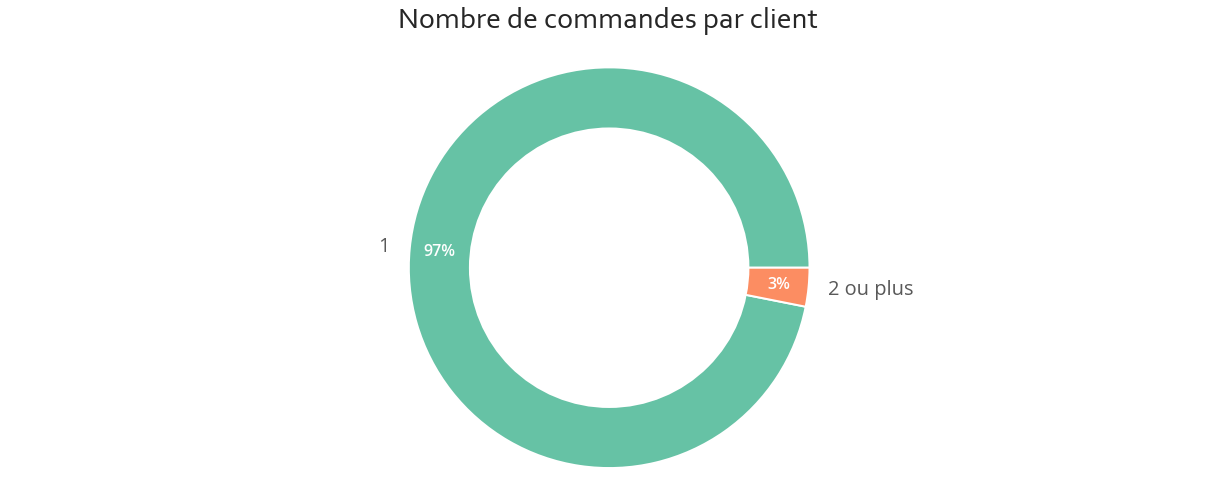

In [73]:
customers = master_dataset.groupby('customer_unique_id')['order_id'].count().reset_index()

orders_n = pd.DataFrame(customers['order_id'].apply(lambda row: '2 ou plus' if row > 1
                                                    else row))

toolbox.plot_donut(orders_n, 'order_id',
                   'Nombre de commandes par client', (17, 7))

<h4 style="font-family:Corbel Light; color:#737373">Traitement des valeurs manquantes</h4>

In [74]:
toolbox.missing_values_by_column(master_dataset)

,FEATURES,Number of Missing Values,Missing Values (%)
0,order_id,0,0.00
13,order_hour,0,0.00
12,order_weekday,0,0.00
10,customer_city,0,0.00
9,customer_zip_code_prefix,0,0.00
8,customer_unique_id,0,0.00
7,order_estimated_delivery_date,0,0.00
11,customer_state,0,0.00
3,order_purchase_timestamp,0,0.00
2,order_status,0,0.00


In [75]:
master_dataset_before_imputation = master_dataset.copy()

- Nous avons une commande pour laquelle il manque toutes les informations concernant le réglement. Nous allons approximer le montant total de la commande par la somme du prix et des frais de port.

In [76]:
master_dataset.loc[master_dataset['payment_value'].isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,delivery_days_n,delay_days_n,payment_value,payment_type_n,payment_installments_n,voucher,products_n,price,freight_value,review_score
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23,14600,...,54.00,36.00,NaN,NaN,NaN,NaN,3.00,134.97,8.49,1.00


In [77]:
(round(master_dataset['payment_value'], 0) == round(
    master_dataset['price'] + master_dataset['freight_value'], 0)).value_counts()

True     98406
False     1035
dtype: int64

In [78]:
master_dataset = toolbox.fill_with_sum(master_dataset,
                                       'payment_value',
                                       'price',
                                       'freight_value',
                                        verbose=True)

1 valeur(s) remplacée(s)


- Pour 775 commandes, le nombre de produits achetés n'est pas renseigné. Nous allons calculer le coût d'un "produit moyen" afin de pouvoir déduire le nombre de produits commandés à partir du montant dépensé.

In [79]:
master_dataset = toolbox.fill_with_average_cost(master_dataset,
                                                'products_n',
                                                'payment_value',
                                                verbose=True)

775 valeur(s) remplacée(s)


- Il manque également des notes de satisfaction client. Nous allons les remplacer par le score moyen attribué par les clients sur une commande.

In [80]:
master_dataset['review_score'].mean()

4.086376212337721

In [81]:
master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'review_score',
                                        verbose=True)

768 valeur(s) remplacée(s)


- Pour certaines commandes, il manque également le nombre de jours entre la commande et la livraison ainsi que le retard de livraison. 
- Pour une seule commande, il manque le nombre de moyens de paiement utilisés, le nombre de coupons utilisés et le nombre de versements choisi.

Nous allons remplacer ces valeurs manquantes par leur moyenne.

In [82]:
master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'delivery_days_n',
                                        verbose=True)

master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'delay_days_n',
                                        verbose=True)

master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'payment_type_n',
                                        verbose=True)

master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'voucher',
                                        verbose=True)

master_dataset = toolbox.fill_with_mean(master_dataset,
                                        'payment_installments_n',
                                        verbose=True)

2_965 valeur(s) remplacée(s)
2_965 valeur(s) remplacée(s)
1 valeur(s) remplacée(s)
1 valeur(s) remplacée(s)
1 valeur(s) remplacée(s)


Il manque encore des valeurs pour certaines variables, mais nous n'allons pas nous en servir.

In [83]:
master_dataset.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_weekday                       0
order_hour                          0
delivery_days_n                     0
delay_days_n                        0
payment_value                       0
payment_type_n                      0
payment_installments_n              0
voucher                             0
products_n                          0
price                             775
freight_value                     775
review_score                        0
dtype: int64

Enfin, vérifions que ces imputations n'ont pas changé la distribution des variables.

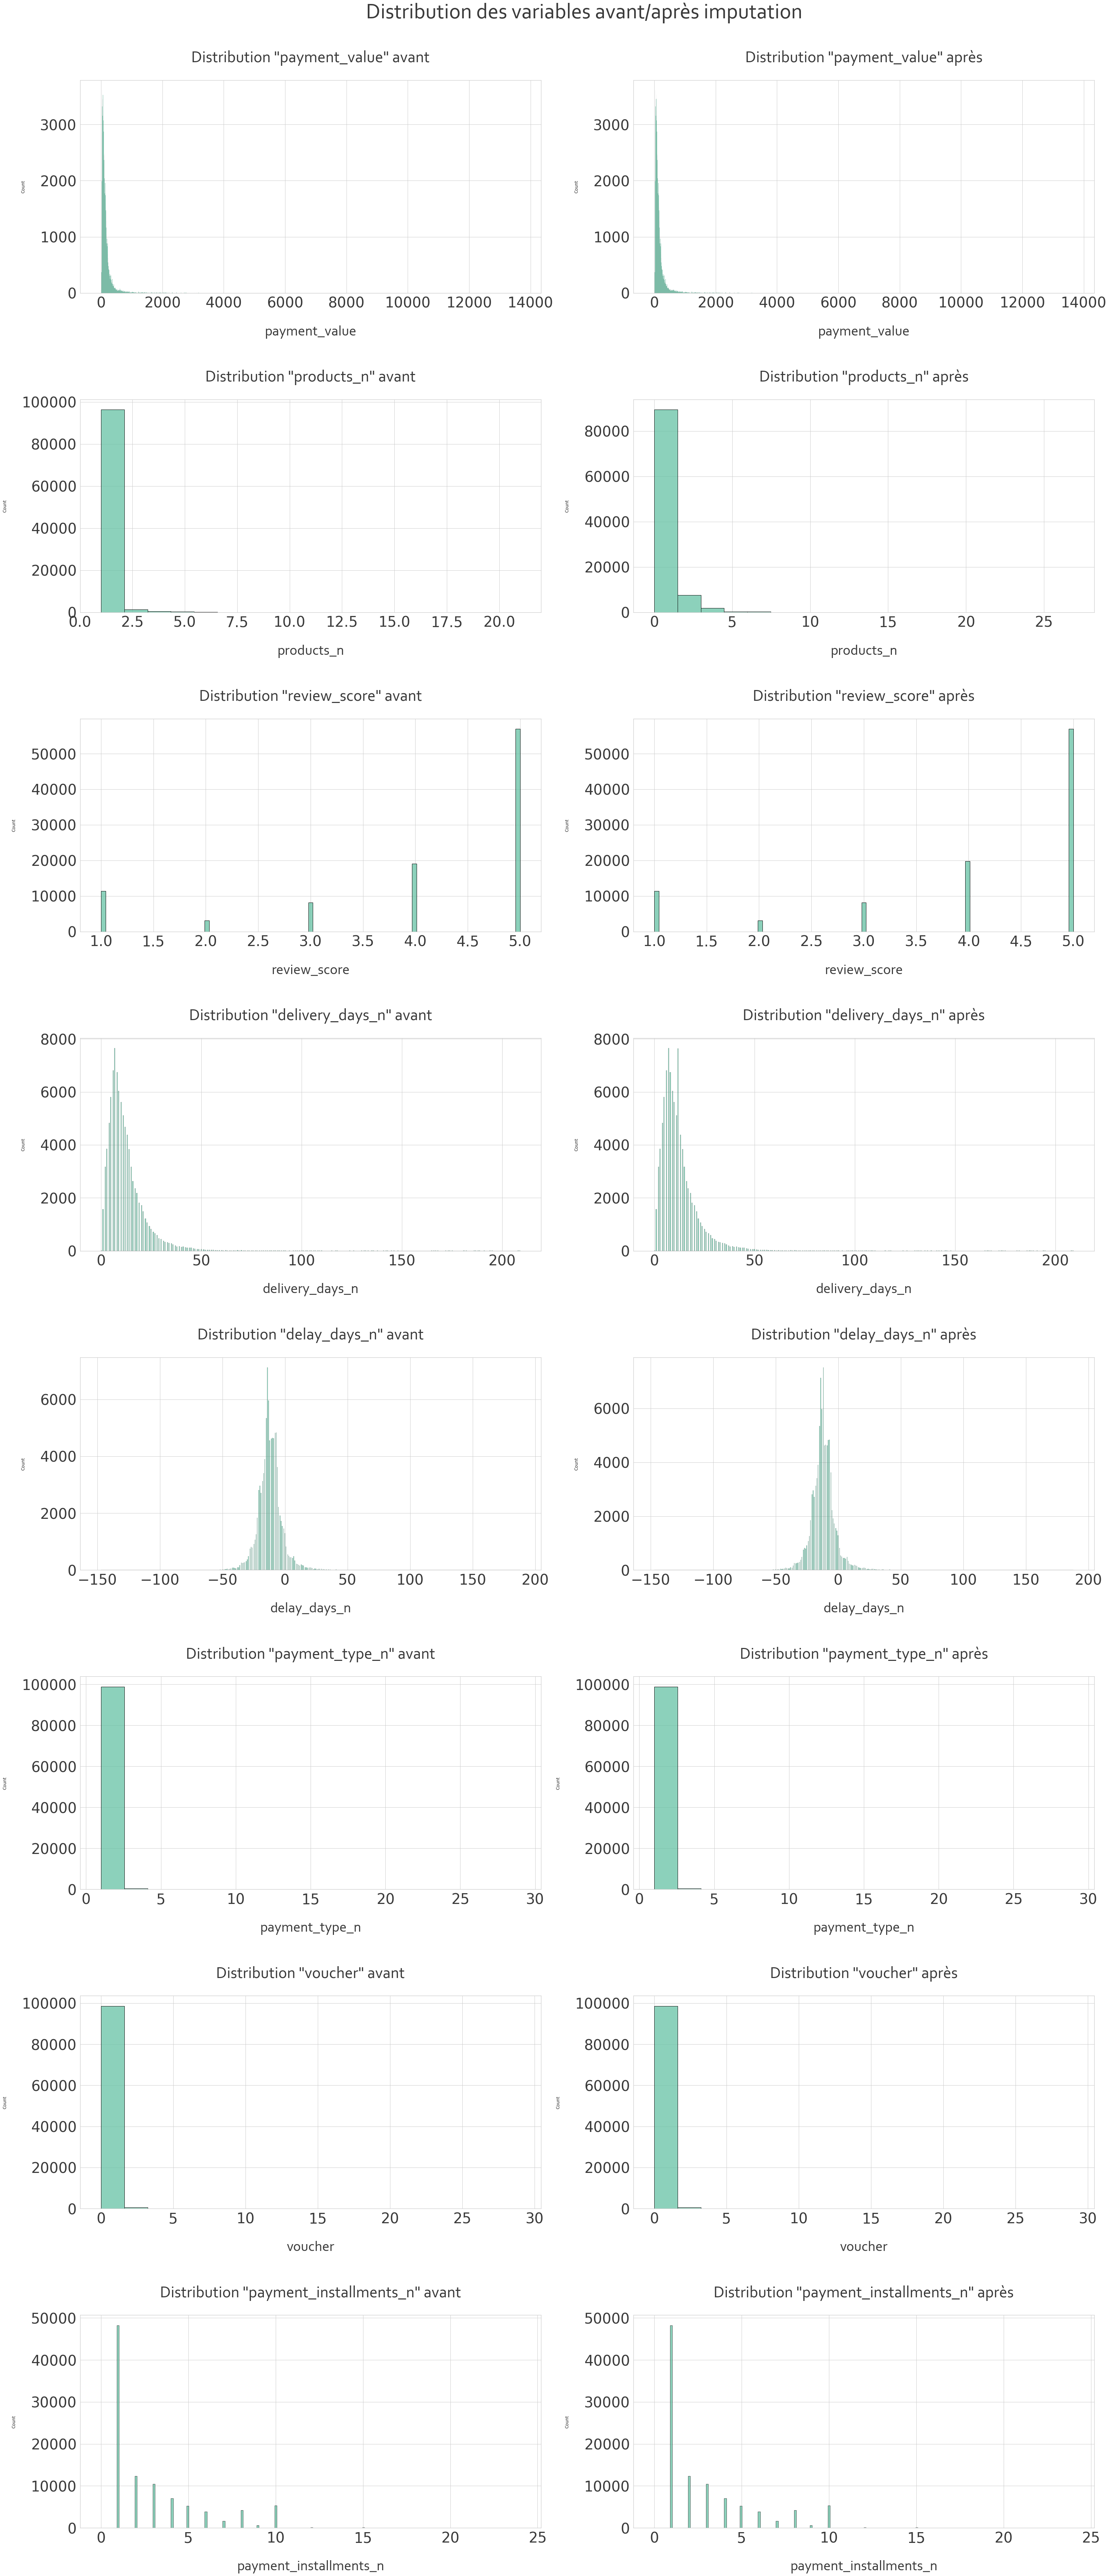

In [84]:
imputed_features = ['payment_value', 'products_n', 'review_score', 
                    'delivery_days_n', 'delay_days_n', 'payment_type_n', 
                    'voucher', 'payment_installments_n'
                   ]

toolbox.plot_dist_comparison(master_dataset_before_imputation, master_dataset, imputed_features, 
                             'des variables avant/après imputation\n', (40, 100), top=0.95)

<h3 style="font-family:Corbel Light; color:#737373">Feature Engineering</h3>

<h4 style="font-family:Corbel Light; color:#737373">Segmentation comportementale</h4>

Pour analyser le comportement des clients vis à vis des produits et services proposés par Olist, nous pouvons étudier les variables ci-dessous. Nous verrons dans la partie "modélisation" lesquelles apportent le plus d'informations facilement exploitables par le service marketing.

- nombre de commandes
- montant total dépensé sur le site
- nombre de jours depuis la dernière commande
- nombre moyen de produits achetés par commande
- note de satisfaction moyenne


- nombre moyen de versements
- nombre de moyen de paiements utilisés en moyenne
- most frequent order day (commande en semaine ou le weekend)
- most frequent order time (commande la nuit ou le jour)
- nombre de vouchers utilisés en moyenne par commande
- différence entre la date d'achat et la date de livraison
- retard de livraison

In [85]:
behavioral_data = master_dataset.groupby('customer_unique_id').agg({'payment_value': 'sum',
                                                                          'payment_type_n': 'mean',
                                                                          'payment_installments_n': 'mean',
                                                                          'order_id': 'count',
                                                                          'order_purchase_timestamp': 'max',
                                                                          'products_n': 'mean',
                                                                          'review_score': 'mean',
                                                                          'order_weekday': [toolbox.get_mode],
                                                                          'order_hour': [toolbox.get_mode],
                                                                          'voucher': 'mean',
                                                                          'delivery_days_n': 'mean',
                                                                          'delay_days_n': 'mean'}).reset_index()

In [86]:
behavioral_data = behavioral_data.droplevel(1, axis=1)
behavioral_data.rename(columns={'payment_value': 'payment_value_total',
                                'payment_installments_n': 'payment_installments_mean',
                                'payment_type_n': 'payment_type_mean',
                                'order_id': 'order_n',
                                'products_n': 'products_mean',
                                'order_purchase_timestamp': 'last_order_timestamp',
                                'order_weekday': 'order_weekday_mode',
                                'order_hour': 'order_hour_mode',
                                'review_score': 'review_score_mean',
                                'voucher': 'voucher_mean'
                                }, inplace=True)

- Ajoutons le nombre de jours entre la date de fin de notre jeu de données et la dernière commande passée par chaque client

In [87]:
most_recent_order = behavioral_data['last_order_timestamp'].max()
behavioral_data['days_since_last_purchase'] = (most_recent_order - behavioral_data['last_order_timestamp']).dt.days

behavioral_data.drop(columns=['last_order_timestamp'], inplace=True)

<h4 style="font-family:Corbel Light; color:#737373">Inspection des nouvelles données</h4>

In [88]:
behavioral_data.head()

,customer_unique_id,payment_value_total,payment_type_mean,payment_installments_mean,order_n,products_mean,review_score_mean,order_weekday_mode,order_hour_mode,voucher_mean,delivery_days_n,delay_days_n,days_since_last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1.00,8.00,1,1.00,5.00,3,10,0.00,6.00,-5.00,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1.00,1.00,1,1.00,4.00,0,11,0.00,3.00,-5.00,163
2,0000f46a3911fa3c0805444483337064,86.22,1.00,8.00,1,1.00,3.00,4,21,0.00,25.00,-2.00,585
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1.00,4.00,1,1.00,4.00,3,20,0.00,20.00,-12.00,369
4,0004aac84e0df4da2b147fca70cf8255,196.89,1.00,6.00,1,1.00,5.00,1,19,0.00,13.00,-8.00,336


Vérifions qu'on a toujours 96_096 clients différents

In [89]:
print('Dimensions du jeu de données :', behavioral_data.shape)
behavioral_data['customer_unique_id'].duplicated().value_counts()

Dimensions du jeu de données : (96096, 13)


False    96096
Name: customer_unique_id, dtype: int64

Vérifions qu'il ne manque aucune valeur

In [90]:
behavioral_data.isnull().sum()

customer_unique_id           0
payment_value_total          0
payment_type_mean            0
payment_installments_mean    0
order_n                      0
products_mean                0
review_score_mean            0
order_weekday_mode           0
order_hour_mode              0
voucher_mean                 0
delivery_days_n              0
delay_days_n                 0
days_since_last_purchase     0
dtype: int64

Regardons les principales statistiques associées à ce jeu de données

In [91]:
behavioral_data.describe()

,payment_value_total,payment_type_mean,payment_installments_mean,order_n,products_mean,review_score_mean,voucher_mean,delivery_days_n,delay_days_n,days_since_last_purchase
count,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00,96_096.00
mean,166.59,1.04,2.92,1.03,1.14,4.08,0.06,12.10,-11.85,287.74
std,231.43,0.38,2.69,0.21,0.57,1.34,0.42,9.41,9.99,153.41
min,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,-147.00,0.00
25%,63.12,1.00,1.00,1.00,1.00,4.00,0.00,6.00,-17.00,163.00
50%,108.00,1.00,2.00,1.00,1.00,5.00,0.00,10.00,-12.00,268.00
75%,183.53,1.00,4.00,1.00,1.00,5.00,0.00,15.00,-7.00,397.00
max,13_664.08,29.00,24.00,17.00,26.89,5.00,29.00,209.00,188.00,772.00


In [92]:
behavioral_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         96096 non-null  object 
 1   payment_value_total        96096 non-null  float64
 2   payment_type_mean          96096 non-null  float64
 3   payment_installments_mean  96096 non-null  float64
 4   order_n                    96096 non-null  int64  
 5   products_mean              96096 non-null  float64
 6   review_score_mean          96096 non-null  float64
 7   order_weekday_mode         96096 non-null  object 
 8   order_hour_mode            96096 non-null  object 
 9   voucher_mean               96096 non-null  float64
 10  delivery_days_n            96096 non-null  float64
 11  delay_days_n               96096 non-null  float64
 12  days_since_last_purchase   96096 non-null  int64  
dtypes: float64(8), int64(2), object(3)
memory usag

<h3 style="font-family:Corbel Light; color:#737373">Analyse des variables</h3>

Remarque : Pour que le notebook de modélisation soit plus léger, j'ai seulement laissé les essais de modèles avec 3, 4 et 5 variables. 
De même ici, j'ai laissé uniquement l'analyse de 5 variables, pour détailler la méthodologie employée.

In [93]:
columns_to_keep = ['customer_unique_id',
                   'days_since_last_purchase',
                   'order_n',
                   'payment_value_total',
                   'review_score_mean',
                   'products_mean']

customer_data = behavioral_data[columns_to_keep]
customer_data.set_index('customer_unique_id', inplace=True)

In [94]:
customer_data.shape

(96096, 5)

<h4 style="font-family:Corbel Light; color:#737373">Matrice de corrélation</h4>

Par curiosité, regardons si nous avons des variables très corrélées linéairement entre elles.

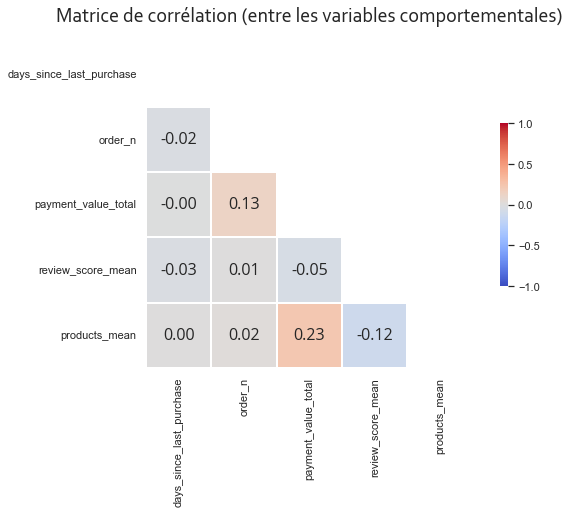

In [95]:
correlation_matrix = customer_data.corr()
title = 'Matrice de corrélation (entre les variables comportementales)'

toolbox.plot_heatmap_correlation_matrix(correlation_matrix,
                                        title, (10, 6), 'coolwarm')

<h4 style="font-family:Corbel Light; color:#737373">Distribution des variables</h4>

Testons différentes transformations et regardons leur impact sur la distribution des variables :
- appliquons une transformation logarithmique sur la variable "payment_value_total"
- transformons la variable "order_n" en variable binaire.
- appliquons un StandardScaler() aux autres variables numériques. Le but étant d'aider nos modèles, tels que le KMeans qui utilise la distance euclidienne, en mettant toutes les variables au même ordre de grandeur.

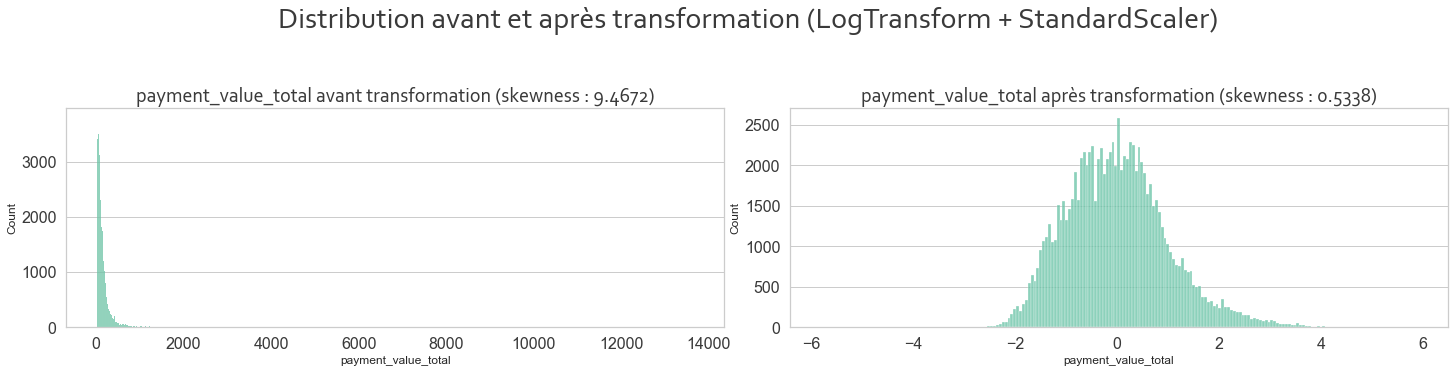

In [105]:
toolbox.test_transformer(customer_data, ['payment_value_total'], [FunctionTransformer(np.log1p), StandardScaler()],
                         'LogTransform + StandardScaler', (20, 5), top=0.7)

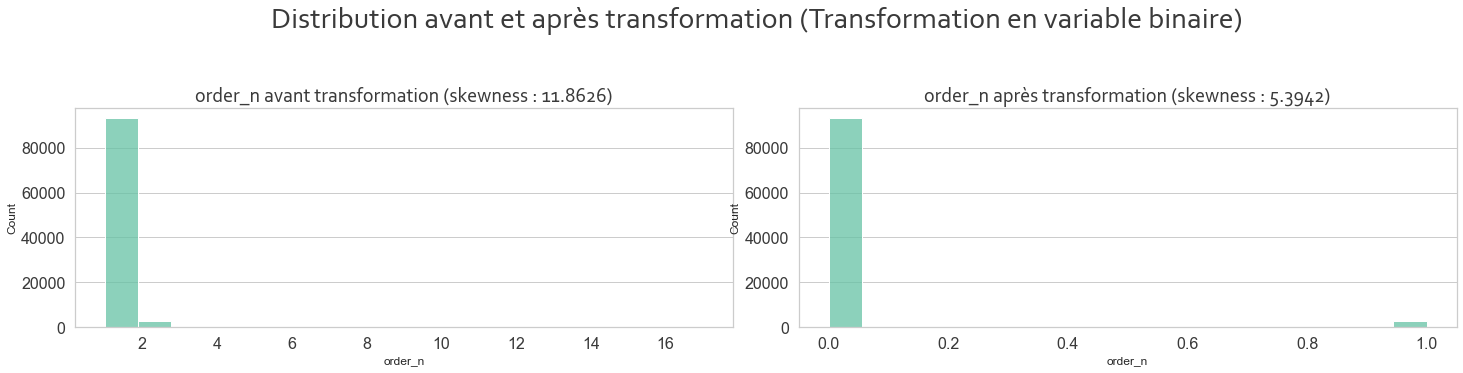

In [102]:
toolbox.test_transformer(customer_data, ['order_n'], [Binarizer(threshold=1)],
                         'Transformation en variable binaire', (20, 5), top=0.7)

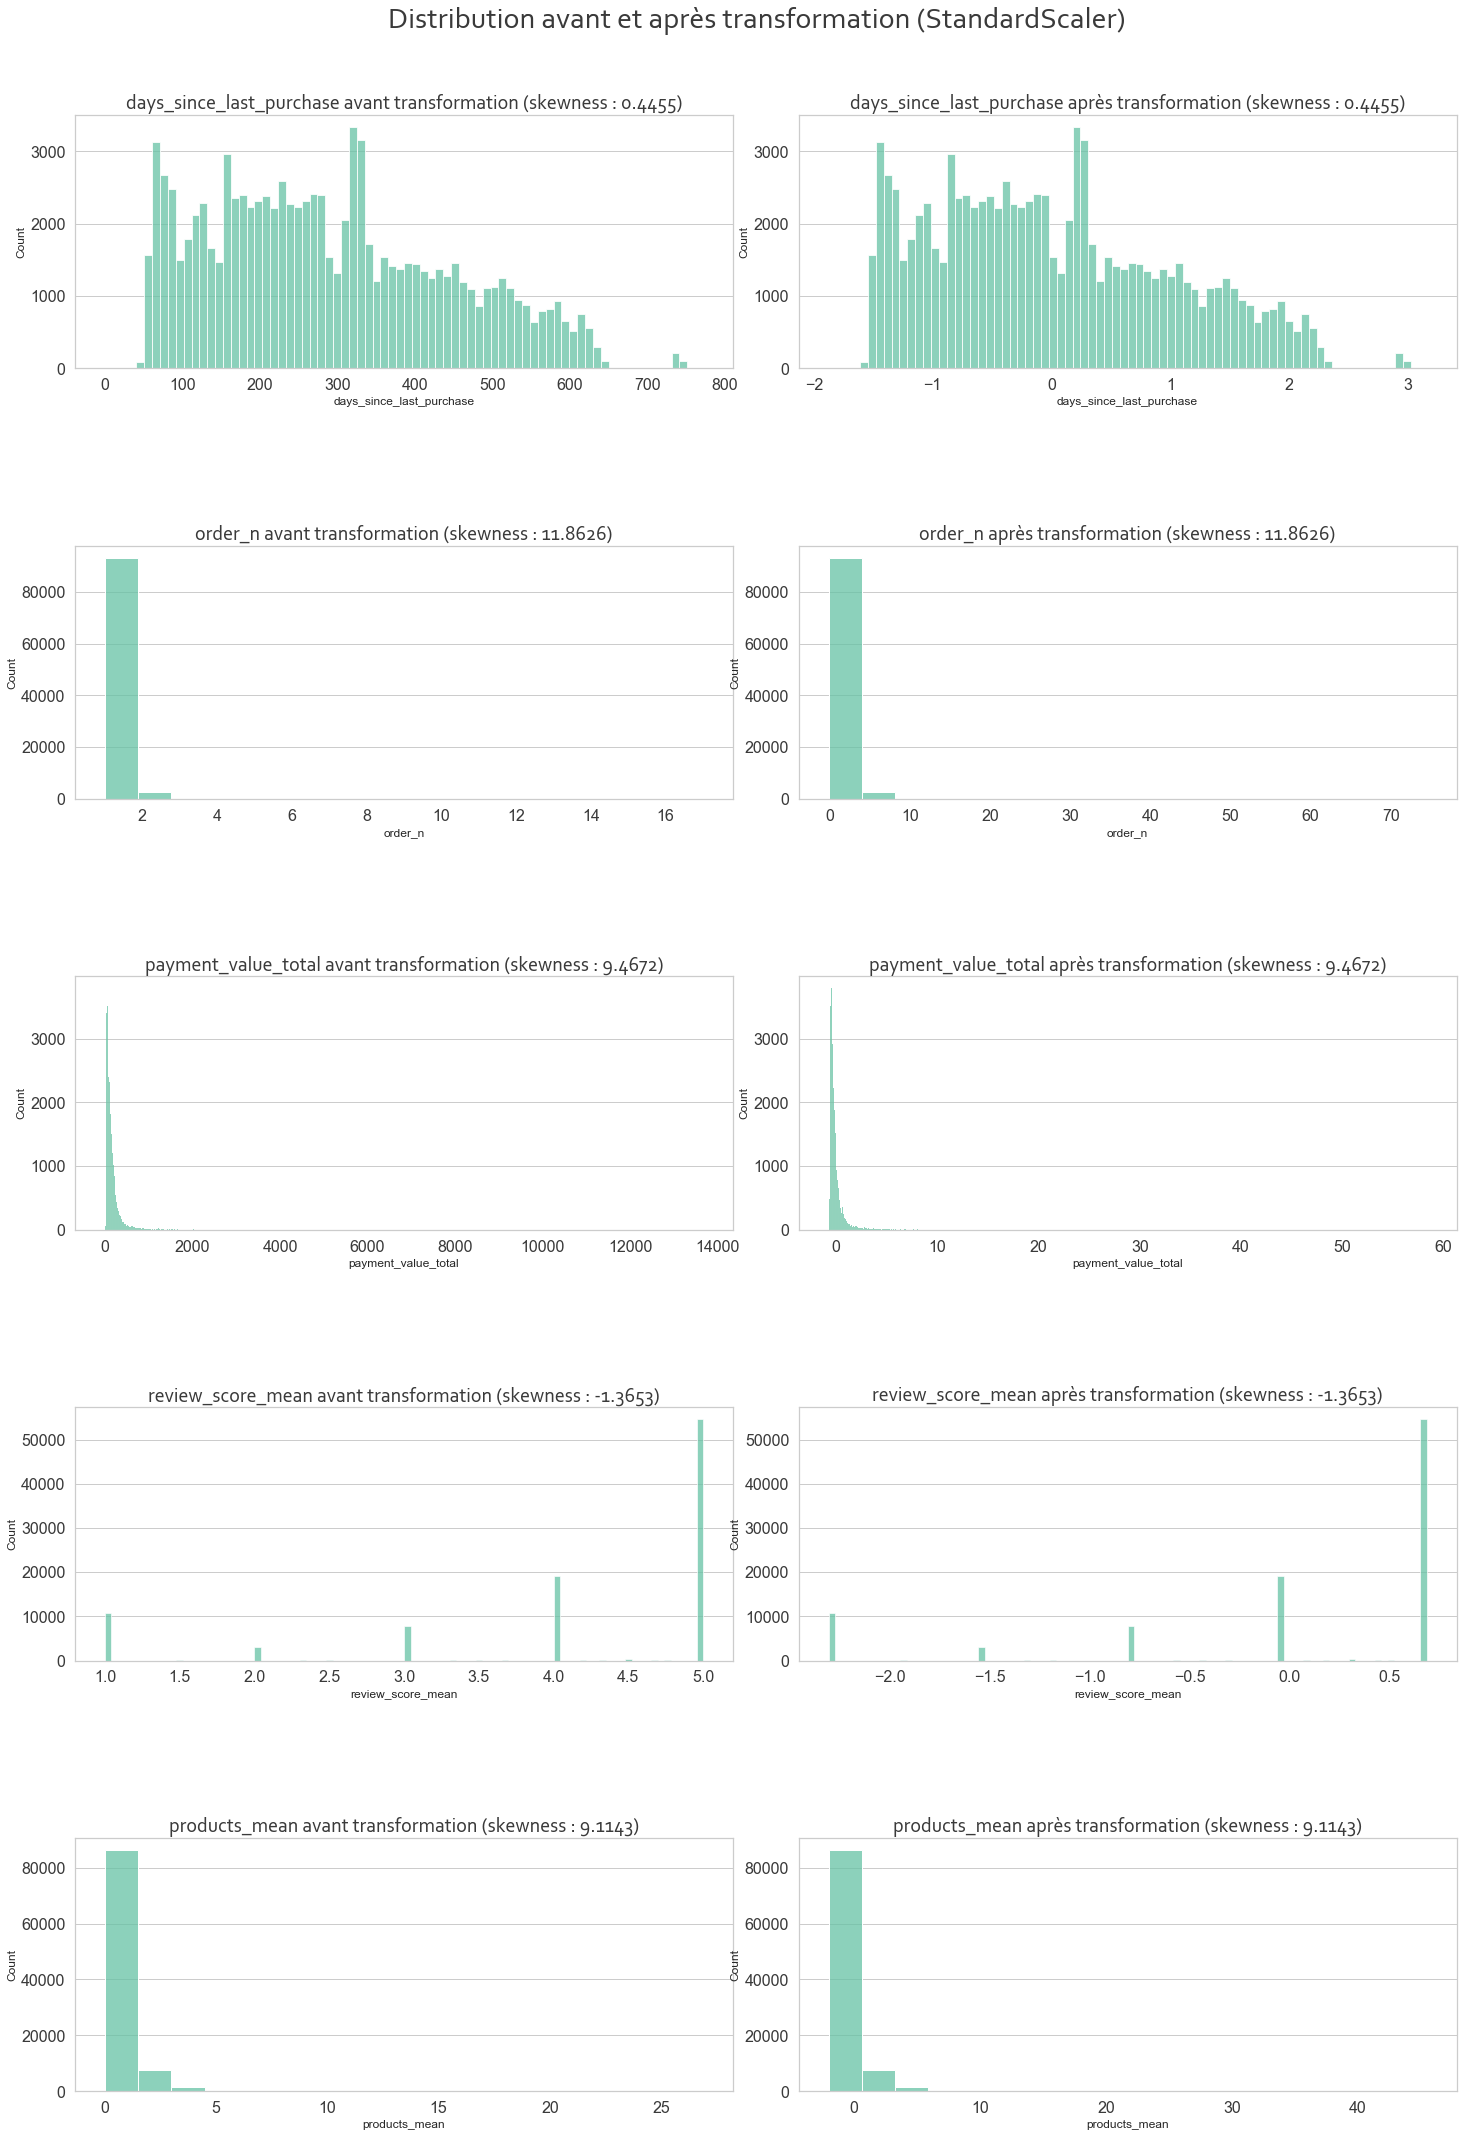

In [98]:
toolbox.test_transformer(customer_data, customer_data.columns.values, [StandardScaler()],
                         'StandardScaler', (20, 30), top=0.93)

<h4 style="font-family:Corbel Light; color:#737373">ACP</h4>

Nous utilisons peu de variables dans les modèles testés (max 5). Donc appliquer une ACP pour réduire les dimensions du jeu de données ne semble pas très utile. 
Essayons quand même de voir si on peut réduire notre jeu de données à 2 dimensions pour différentes combinaisons de variables (3, 4, 5 features).

Conclusion : les deux premières composantes principales ne conservent pas suffisamment de la variance globale du jeu de données. On ne peut donc pas les utiliser pour bien visualiser les données en seulement 2 dimensions.

<h5 style="font-family:Corbel Light; color:#737373">RFM</h5>

In [99]:
X_rfm = customer_data.drop(columns=['review_score_mean', 'products_mean'])
X_rfm.shape

(96096, 3)

In [100]:
pca_rfm = toolbox.fit_transform_pca(X_rfm, 3)

Pourcentage de variance expliquée par la première composante : 37.64%
Pourcentage de variance expliquée par les 2 premières composantes ensembles : 70.93%
Pourcentage de variance expliquée par les 3 premières composantes ensembles : 100.00%


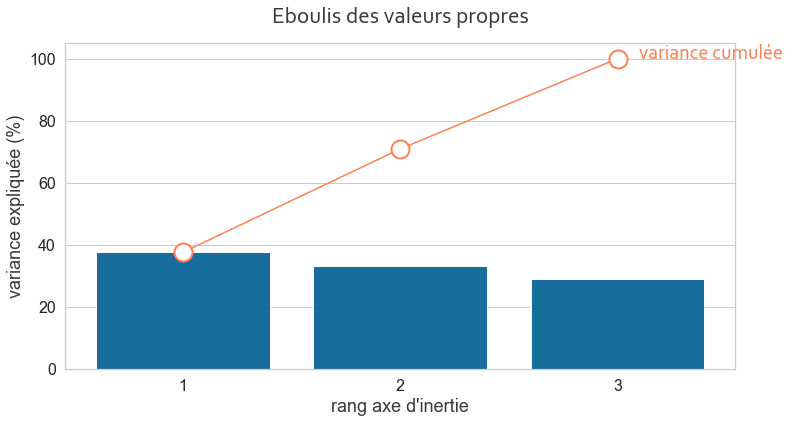

In [101]:
color = sns.desaturate(sns.color_palette('colorblind')[0], 0.75)
titles = {'chart_title': 'Eboulis des valeurs propres',
          'x_label': 'rang axe d\'inertie',
          'y_label': 'variance expliquée (%)'}

toolbox.plot_screeplot(pca_rfm, 3, (12, 6), titles, color, 3.1, 100)

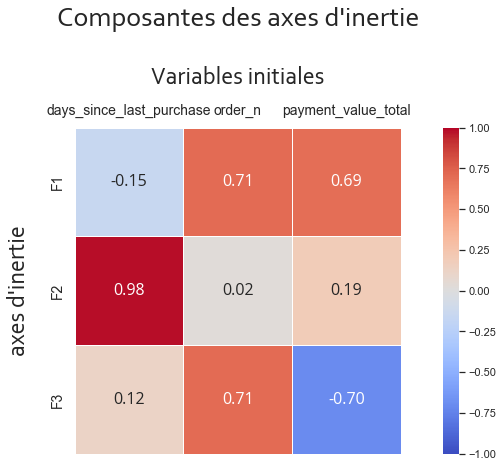

In [102]:
pcs_df = pd.DataFrame(data=pca_rfm.components_,
                      index=['F' + str(s) for s in range(1, 4)],
                      columns=X_rfm.columns.values)

titles = {'chart_title': 'Composantes des axes d\'inertie',
          'y_title': 'axes d\'inertie',
          'x_title': 'Variables initiales'}

toolbox.plot_heatmap(pcs_df, 1, titles, (15, 6),
                     "0.2f", True, -1, 'coolwarm', True)

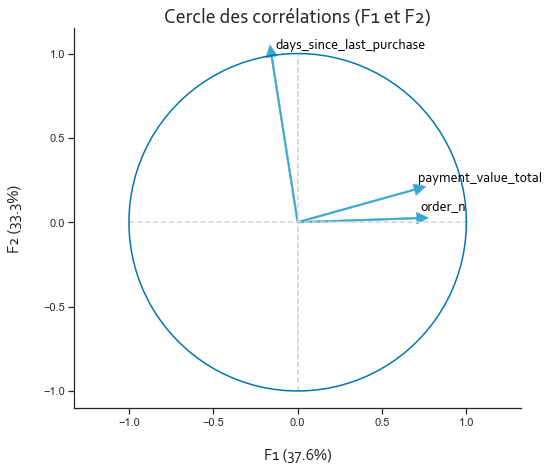

In [103]:
color = sns.color_palette('husl', 8)[5]

toolbox.plot_correlation_circle(pca_rfm, 0, 1, (8, 7),
                                X_rfm.columns.values, color)

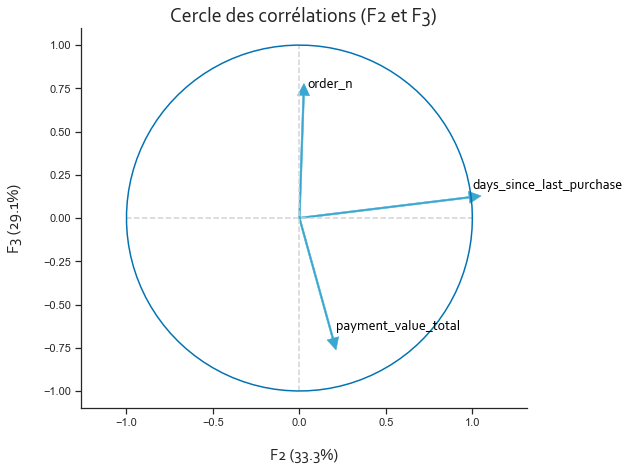

In [104]:
toolbox.plot_correlation_circle(pca_rfm, 1, 2, (8, 7),
                                X_rfm.columns.values, color)

F1 : positivement corrélé avec le nombre de commandes et le montant total commandé -> gros clients vs petits clients

F2 : positivement corrélé avec le nombre de jours depuis la dernière commande -> anciens clients vs clients récents

F3: positivement corrélé avec le nombre de commandes et anti-corrélé avec le montant total des commandes -> clients qui commandent beaucoup mais pour petit montant vs clients qui ont fait une grosse commande

<h5 style="font-family:Corbel Light; color:#737373">ACP (4 variables : RFM + nombre moyen de produits par commande) </h5>

In [105]:
X_rfm_products = customer_data.drop(columns=['review_score_mean'])
X_rfm_products.shape

(96096, 4)

In [106]:
pca_rfm_products = toolbox.fit_transform_pca(X_rfm_products, 3)

Pourcentage de variance expliquée par la première composante : 31.86%
Pourcentage de variance expliquée par les 2 premières composantes ensembles : 57.20%
Pourcentage de variance expliquée par les 3 premières composantes ensembles : 81.36%


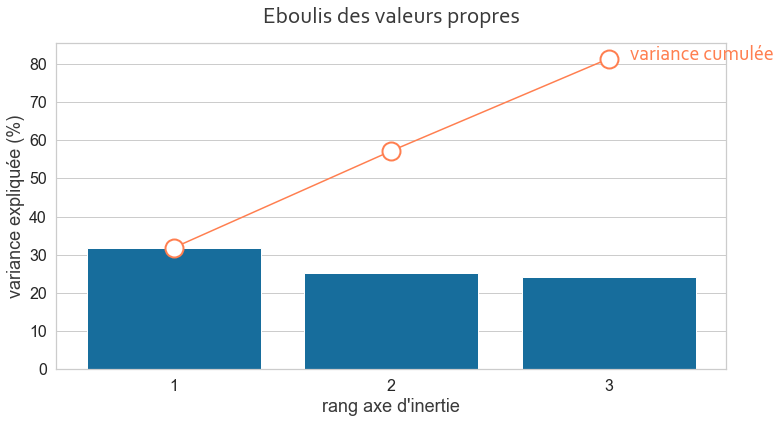

In [107]:
color = sns.desaturate(sns.color_palette('colorblind')[0], 0.75)
titles = {'chart_title': 'Eboulis des valeurs propres',
          'x_label': 'rang axe d\'inertie',
          'y_label': 'variance expliquée (%)'}

toolbox.plot_screeplot(pca_rfm_products, 3, (12, 6), titles, color, 3.1, 81)

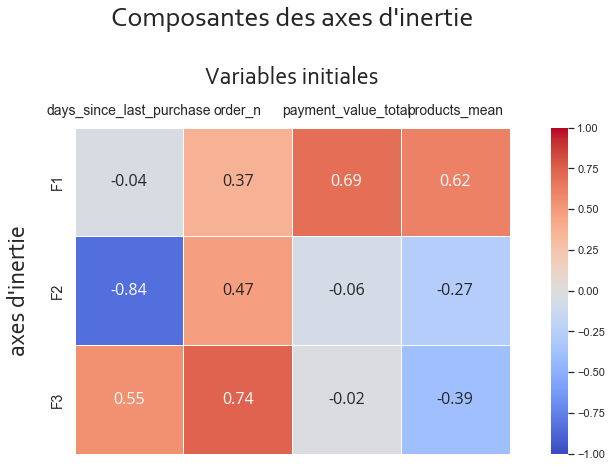

In [108]:
pcs_df = pd.DataFrame(data=pca_rfm_products.components_,
                      index=['F' + str(s) for s in range(1, 4)],
                      columns=X_rfm_products.columns.values)

titles = {'chart_title': 'Composantes des axes d\'inertie',
          'y_title': 'axes d\'inertie',
          'x_title': 'Variables initiales'}

toolbox.plot_heatmap(pcs_df, 1, titles, (15, 6),
                     "0.2f", True, -1, 'coolwarm', True)

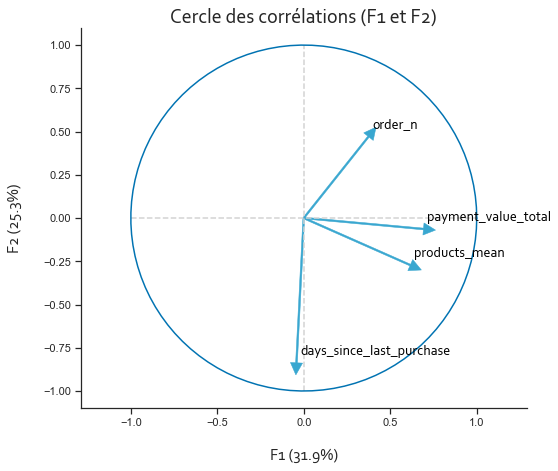

In [109]:
color = sns.color_palette('husl', 8)[5]

toolbox.plot_correlation_circle(pca_rfm_products, 0, 1, (8, 7),
                                X_rfm_products.columns.values, color)

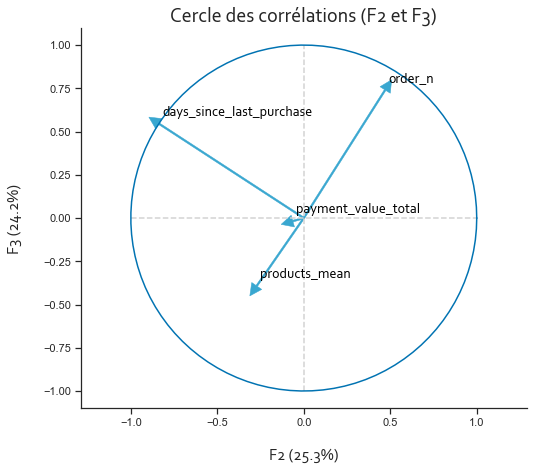

In [110]:
toolbox.plot_correlation_circle(pca_rfm_products, 1, 2, (8, 7),
                                X_rfm_products.columns.values, color)

F1 : positivement corrélé avec le montant total de la commande et le nombre moyen de produit par commande -> gros clients (grosses commandes : a acheté beaucoup de produits et dépensé beaucoup) vs petits clients (petite commandes)

F2 : anti-corrélé avec le nombre de jours depuis la dernière commande -> clients récents vs anciens clients

F3 : positivement corrélé avec le nombre de commandes -> clients ayant commandé plusieurs fois vs clients ayant commandé une fois

<h5 style="font-family:Corbel Light; color:#737373">ACP (4 variables : RFM + note moyenne) </h5>

In [111]:
X_rfm_review = customer_data.drop(columns=['products_mean'])
X_rfm_review.shape

(96096, 4)

In [112]:
pca_rfm_review = toolbox.fit_transform_pca(X_rfm_review, 4)

Pourcentage de variance expliquée par la première composante : 28.35%
Pourcentage de variance expliquée par les 2 premières composantes ensembles : 54.22%
Pourcentage de variance expliquée par les 3 premières composantes ensembles : 78.43%
Pourcentage de variance expliquée par les 4 premières composantes ensembles : 100.00%


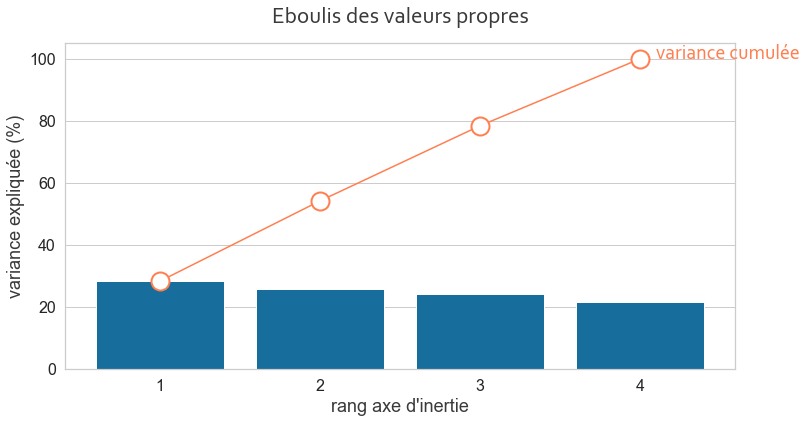

In [113]:
color = sns.desaturate(sns.color_palette('colorblind')[0], 0.75)
titles = {'chart_title': 'Eboulis des valeurs propres',
          'x_label': 'rang axe d\'inertie',
          'y_label': 'variance expliquée (%)'}

toolbox.plot_screeplot(pca_rfm_review, 4, (12, 6), titles, color, 4.1, 100)

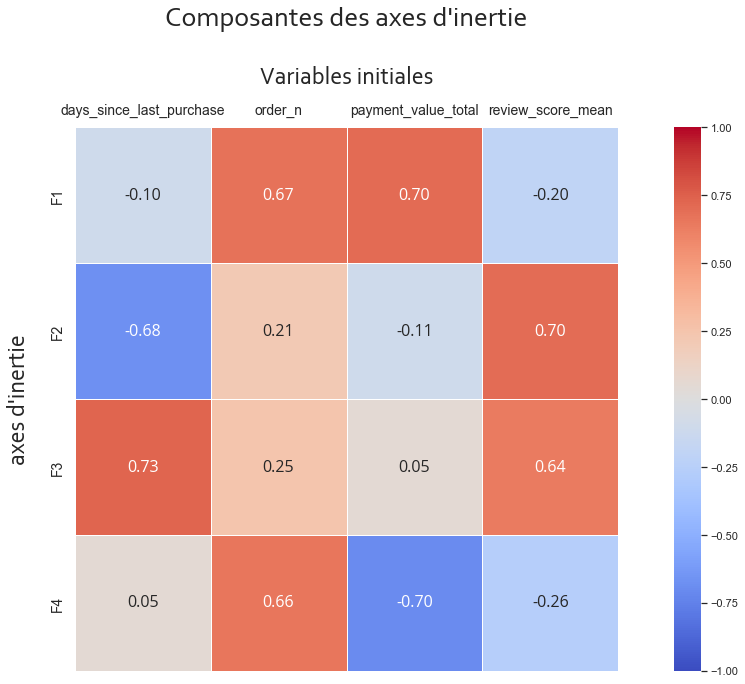

In [114]:
pcs_df = pd.DataFrame(data=pca_rfm_review.components_,
                      index=['F' + str(s) for s in range(1, 5)],
                      columns=X_rfm_review.columns.values)

titles = {'chart_title': 'Composantes des axes d\'inertie',
          'y_title': 'axes d\'inertie',
          'x_title': 'Variables initiales'}

toolbox.plot_heatmap(pcs_df, 1, titles, (20, 10),
                     "0.2f", True, -1, 'coolwarm', True)

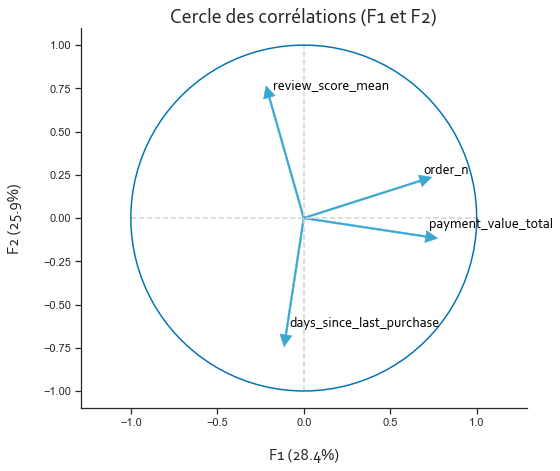

In [115]:
color = sns.color_palette('husl', 8)[5]

toolbox.plot_correlation_circle(pca_rfm_review, 0, 1, (8, 7),
                                X_rfm_review.columns.values, color)

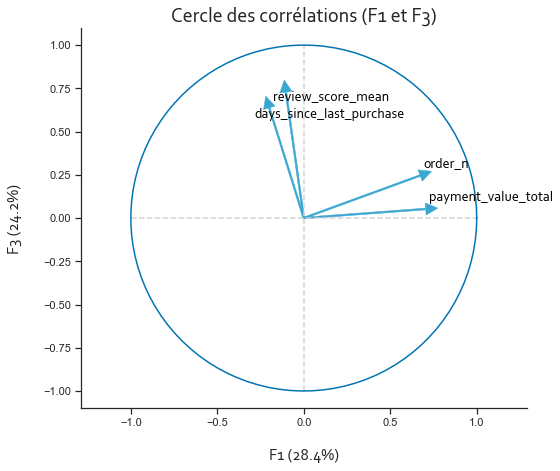

In [116]:
toolbox.plot_correlation_circle(pca_rfm_review, 0, 2, (8, 7),
                                X_rfm_review.columns.values, color)

F1 : positivement corrélé avec le nombre de commandes et le montant total dépensé -> gros clients (ont commandés plusieurs fois et/ou ont beaucoup dépensé)

F2 : anticorrélé avec le nombre de jours depuis la dernière commande et positivement corrélé avec la note moyenne -> clients récents et satisfaits vs anciens clients moins satisfaits

F3 : positivement corrélé avec la note moyenne et positivement corrélé avec le nombre de jours depuis la dernière commande -> anciens clients satisfaits vs clients plus récents et moins satisfaits

<h5 style="font-family:Corbel Light; color:#737373">ACP (5 variables) </h5>

In [117]:
X = customer_data
X.shape

(96096, 5)

In [118]:
pca = toolbox.fit_transform_pca(X, 4)

Pourcentage de variance expliquée par la première composante : 26.18%
Pourcentage de variance expliquée par les 2 premières composantes ensembles : 47.30%
Pourcentage de variance expliquée par les 3 premières composantes ensembles : 66.87%
Pourcentage de variance expliquée par les 4 premières composantes ensembles : 85.21%


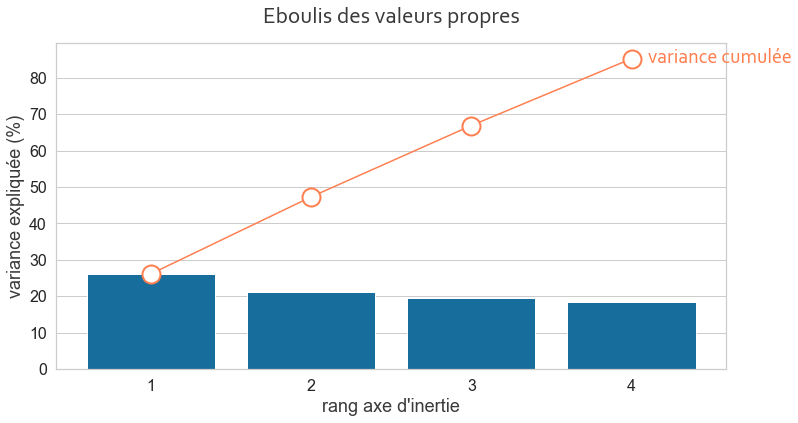

In [119]:
color = sns.desaturate(sns.color_palette('colorblind')[0], 0.75)
titles = {'chart_title': 'Eboulis des valeurs propres',
          'x_label': 'rang axe d\'inertie',
          'y_label': 'variance expliquée (%)'}

toolbox.plot_screeplot(pca, 4, (12, 6), titles, color, 4.1, 84)

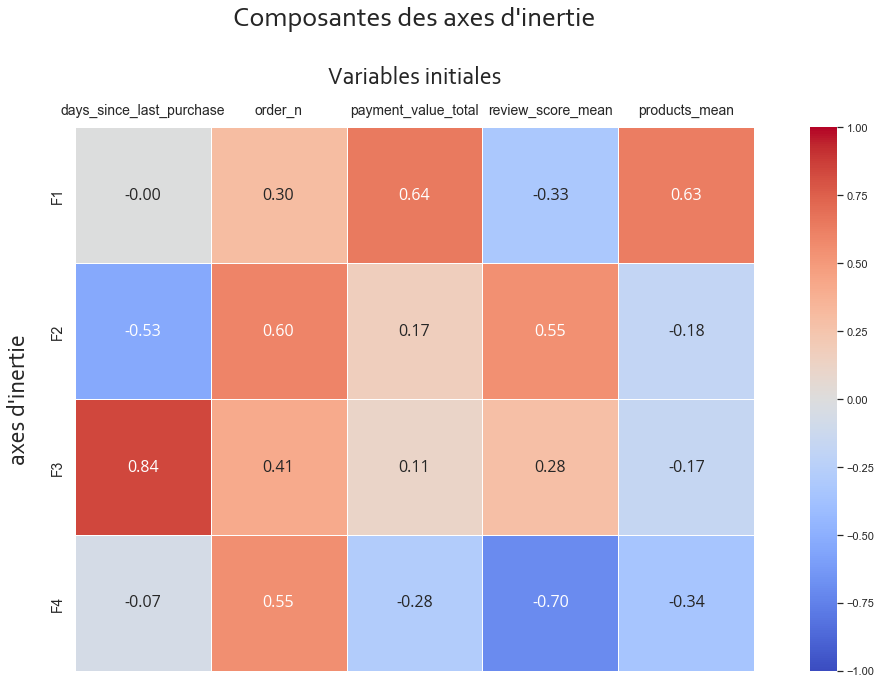

In [120]:
pcs_df = pd.DataFrame(data=pca.components_,
                      index=['F' + str(s) for s in range(1, 5)],
                      columns=X.columns.values)

titles = {'chart_title': 'Composantes des axes d\'inertie',
          'y_title': 'axes d\'inertie',
          'x_title': 'Variables initiales'}

toolbox.plot_heatmap(pcs_df, 1, titles, (20, 10),
                     "0.2f", True, -1, 'coolwarm', True)

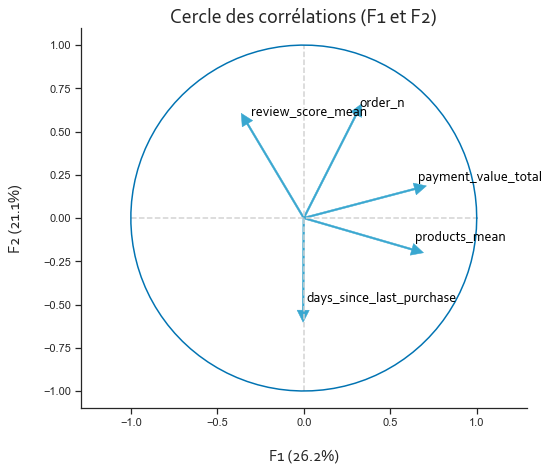

In [121]:
color = sns.color_palette('husl', 8)[5]

toolbox.plot_correlation_circle(pca, 0, 1, (8, 7), X.columns.values, color)

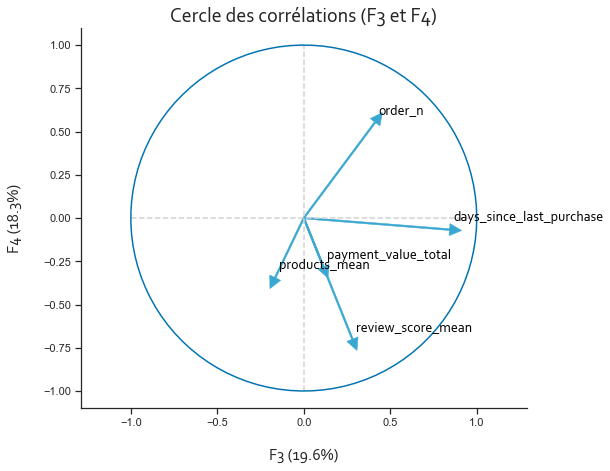

In [122]:
toolbox.plot_correlation_circle(pca, 2, 3, (8, 7), X.columns.values, color)

F1 : positivement corrélé avec montant total de la commande et le nombre de produits moyen par commande -> gros clients (ayant passé de grosses commandes : beaucoup de produits et/ou des produits chers)

F2 : positivement corrélé avec le nombre de commandes -> clients ayant fait plusieurs commandes vs clients ayant fait une commande

F3 : positivement corrélé avec le nombre de jours depuis la dernière commande -> anciens clients vs nouveaux clients

F4 : anticorrélé avec le score moyen -> clients non satisfaits vs clients satisfaits

<h3 style="font-family:Corbel Light; color:#737373">Enregistrement des données</h3>

In [123]:
columns_to_keep = ['customer_unique_id',
                   'days_since_last_purchase',
                   'order_n',
                   'payment_value_total',
                   'review_score_mean',
                   'products_mean']

behavioral_data[columns_to_keep].to_pickle('customer_behavior_data.pkl')